<a href="https://colab.research.google.com/github/Jerry0209/FundamentalLearningEPFL/blob/main/TP7/classification_exercise_v5_Tianrui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Logistic regression and SVM

**What you will learn today**: You will learn how to implement a classifier. First we will analyze a toy example in which we will use a logistic classifier coded from scratch. Once we understood the logic behind the algorithm we will use the black box Sklearn one for recognizing hand-written digits. You will also implement SVM classifier on a different dataset to get familiar with this important family of algorithm.

# 1) Logistic regression from scratch

Let us generate a synthetic dataset using a multivariate Gaussian distribution

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(0)
num_observations = 500

x1 = np.random.multivariate_normal([0, 0], [[1, .5],[.5, 1]], num_observations) # First class of data
x2 = np.random.multivariate_normal([1, 4], [[1, .8],[.8, 1]], num_observations) # Second class of data

dataset = np.vstack((x1, x2)).astype(np.float32)

# np.vstack((x1, x2))
labels = np.hstack((np.zeros(num_observations),np.ones(num_observations)))
# First (num_observations) rows from x1...

dataset[:5] # First five elements

array([[-1.7277927 , -1.3276355 ],
       [-1.9680586 ,  0.27283463],
       [-1.1287137 , -2.1059916 ],
       [-0.7471221 , -0.8984793 ],
       [-0.1159091 ,  0.2946894 ]], dtype=float32)

Let's plot our data

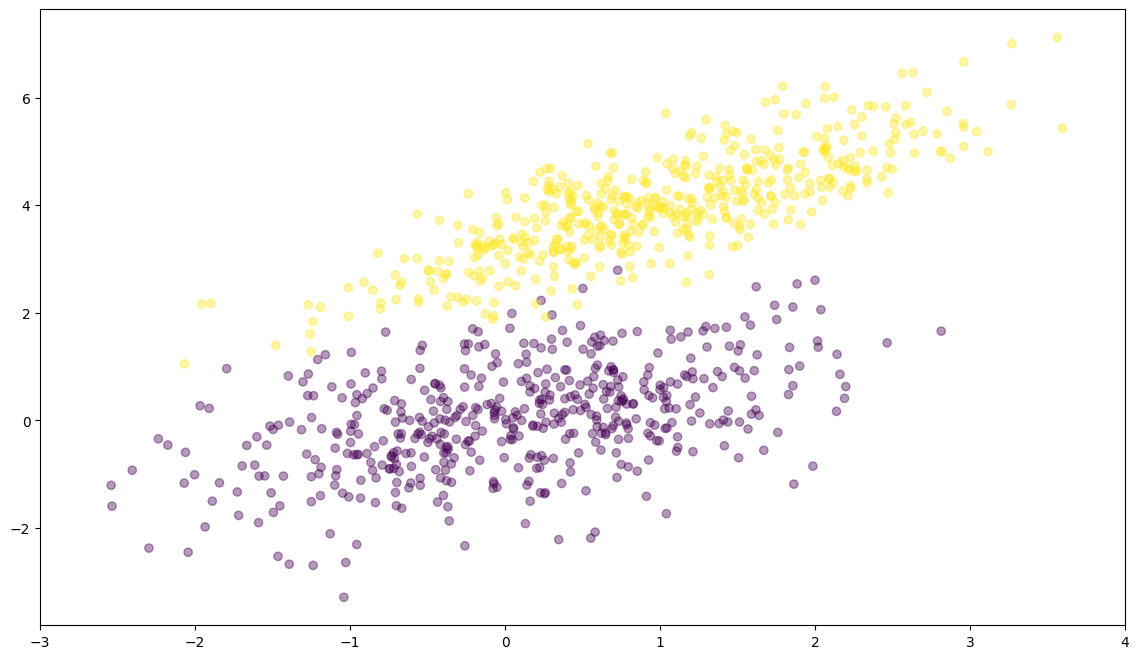

In [21]:
plt.figure(figsize=(14,8))
plt.xlim(-3,4)
plt.scatter(dataset[:, 0], dataset[:, 1],c = labels, alpha = .4)

Our goal is to use a logistic function to fit our dataset. In this case:
$$P_{\rm model}(y_i|{\vec w} \cdot {\vec x_i}) = \frac {e^{({\vec w} \cdot {\vec x_i})y_i}}{1+\exp({\vec w} \cdot {\vec x_i})}$$
such that
$$P_{\rm model}(y_i=1)  = \frac {\exp{({\vec w} \cdot {\vec x_i})}}{1+\exp({\vec w} \cdot {\vec x_i})}  = \frac {1}{1+\exp(-{\vec w} \cdot {\vec x_i})}~~~ \text{and}~~~ P_{\rm model}(y_i=0)  = \frac {1}{1+\exp({\vec w} \cdot {\vec x_i})}  = \frac {\exp{(-{\vec w} \cdot {\vec x_i})}}{1+\exp(-{\vec w} \cdot {\vec x_i})}$$


Now, we can either use the cross-entropy loss and write:
$$\mathcal{L}(\vec{w}) = - \sum_{i=1}^n \sum_{y_i=0,1} y_i \log P_{\rm model}(y_i) +  (1-y_i) \log (1 - P_{\rm model}(y_i)) $$
or equivalently write a maximum-likelihood problem with
$$
\mathcal{L}(\vec{w}|\vec{\bm{x}},\bm{y}) \propto \sum_i \log P_{\rm model}(y_i|{\vec w} \cdot {\vec x_i})
$$
In both cases, the problem boils down to minimizing the following loss:
$$\mathcal{L}(\vec {w}) =  \sum_{i=1}^n - y_i {\vec {w}} \cdot {\vec x}_i  + \log{(1+\exp({\vec w} \cdot {\vec x}_i ))} $$

Let us implement these function:

In [22]:
def sigmoid(scores):
    return 1 / (1 + np.exp(-scores))
def log_loss(features, target, weights):
    scores = np.dot(features, weights)
    ll = np.sum( -target*scores + np.log(1 + np.exp(scores)) ) # The last equation
    return ll

In order to perform optimization, we need to compute the gradient and perform gradient descent. Here we have:

$$\nabla_{\vec w} \mathcal{L}(\vec w) =  \sum_{i = 1}^n - y_i  {\vec x}_i  + {\vec x}_i  \frac{\exp({\vec w} \cdot {\vec x}_i )}{(1+\exp({\vec w} \cdot {\vec x}_i ))} = - \sum_{i = 1}^n {\vec x}_i^T (y_i - P(y_i=1)) $$

We can now write the  logistic regression

##### **Exercise 1**

##### Try writing Gradient Descent using this Loss, as we did in the previous exercise session

In [23]:
def logistic_regression(features, target, num_steps, learning_rate):
    weights = np.zeros(features.shape[1])

    for step in range(num_steps):
        scores = np.dot(features, weights)
        predicton = sigmoid(scores)
        diff = target - predicton
        gradient = -np.dot(features.T, diff)
        weights = weights - learning_rate * gradient

        if step % 10000 == 0:
            print(step, log_loss(features, target, weights))

    return weights

We use the usual trick of adding a "1" to the data so that we can actually linear fitting, and call the regression function

In [24]:
intercept = np.ones((dataset.shape[0], 1))
data_with_intercept = np.hstack((intercept, dataset))

We then run the actual GD algorithm

In [25]:
weights = logistic_regression(data_with_intercept, labels, num_steps = 300000, learning_rate = 5e-5)

0 645.1976320327615
10000 32.751191832359176
20000 27.095065275891347
30000 24.836811224952655
40000 23.593936566289752
50000 22.803112650970398
60000 22.255870323028482
70000 21.855786948699006
80000 21.55169925537929
90000 21.313784058969752
100000 21.123421954281334
110000 20.968362287170734
120000 20.840203784078454
130000 20.732988348642635
140000 20.6423716693823
150000 20.565111368581015
160000 20.498738918089238
170000 20.441342465252287
180000 20.391419037920045
190000 20.347771512096905
200000 20.30943524982975
210000 20.275624876363842
220000 20.245695018470037
230000 20.219110905131664
240000 20.195426054123942
250000 20.174265128187454
260000 20.155310615551997
270000 20.138292375753814
280000 20.12297935729693
290000 20.109172979225384


Now we can plot the prediction from our model, and check how good they are on the training dataset

In [26]:
def line(x,a,b,c):
    return -x*b/c-a/c
def myline(x):
    a = weights[0]
    b = weights[1]
    c = weights[2]
    return -x*b/c-a/c

final_scores = np.dot(data_with_intercept, weights)
preds = np.round(sigmoid(final_scores))

print('Accuracy: {0}'.format((preds == labels).sum().astype(float) / len(preds)))

Accuracy: 0.991


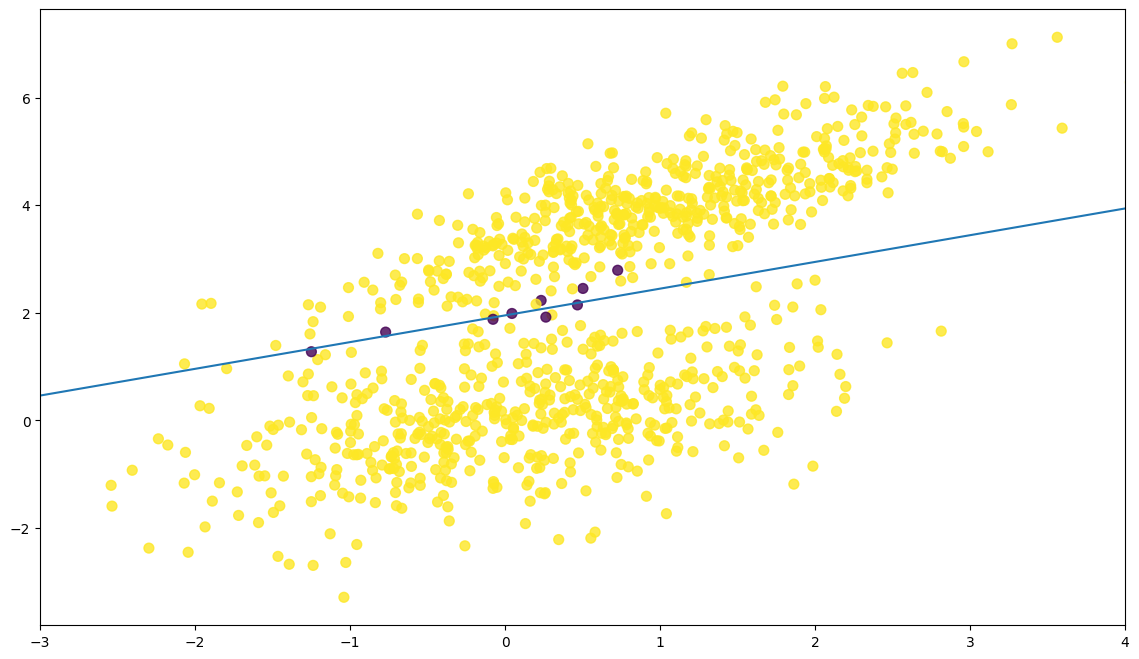

In [27]:
plt.figure(figsize = (14, 8))
plt.scatter(dataset[:, 0], dataset[:, 1],
            c = (preds == labels) , alpha = .8, s = 50)
plt.xlim([-3,4])
plt.plot([-3,4],[myline(-3),myline(4)])

In high dimensional statistics problems, it is often the case that the number of points are of the same order as the dimension. Let us mimick this by using fewer points in dimension 2!

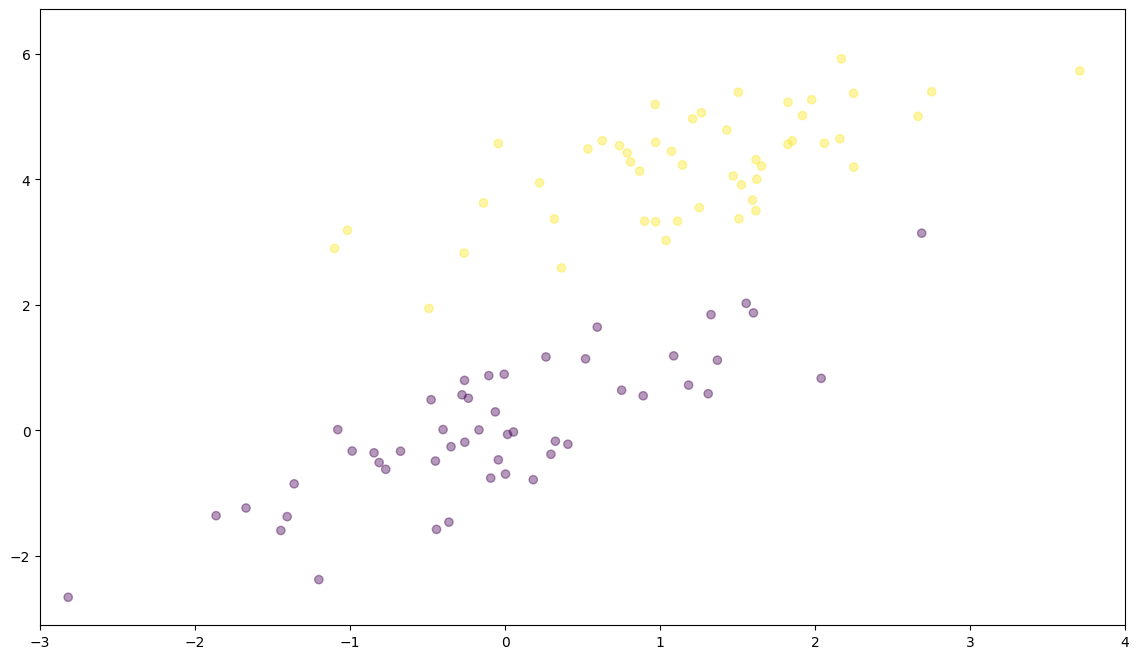

In [28]:
num_observations = 50

x1 = np.random.multivariate_normal([0, 0], [[1, .75],[.75, 1]], num_observations)
x2 = np.random.multivariate_normal([1, 4], [[1, .75],[.75, 1]], num_observations)

dataset = np.vstack((x1, x2)).astype(np.float32)
labels = np.hstack((np.zeros(num_observations),
                              np.ones(num_observations)))
plt.figure(figsize=(14,8))
plt.xlim([-3,4])
plt.scatter(dataset[:, 0], dataset[:, 1], c = labels, alpha = .4)

Of course, we could just redo our fit

In [29]:
intercept = np.ones((dataset.shape[0], 1))
data_with_intercept = np.hstack((intercept, dataset))

weights = logistic_regression(data_with_intercept, labels,num_steps = 100000, learning_rate = 1e-1)

0 296.89887887568767
10000 0.01253836504248739
20000 0.006544884676131536
30000 0.004461906055359928
40000 0.0033958933953699456
50000 0.0027460014174589768
60000 0.002307507437644334
70000 0.0019912936690457475
80000 0.0017522594577792502
90000 0.0015651013439884974


Accuracy: 1.0


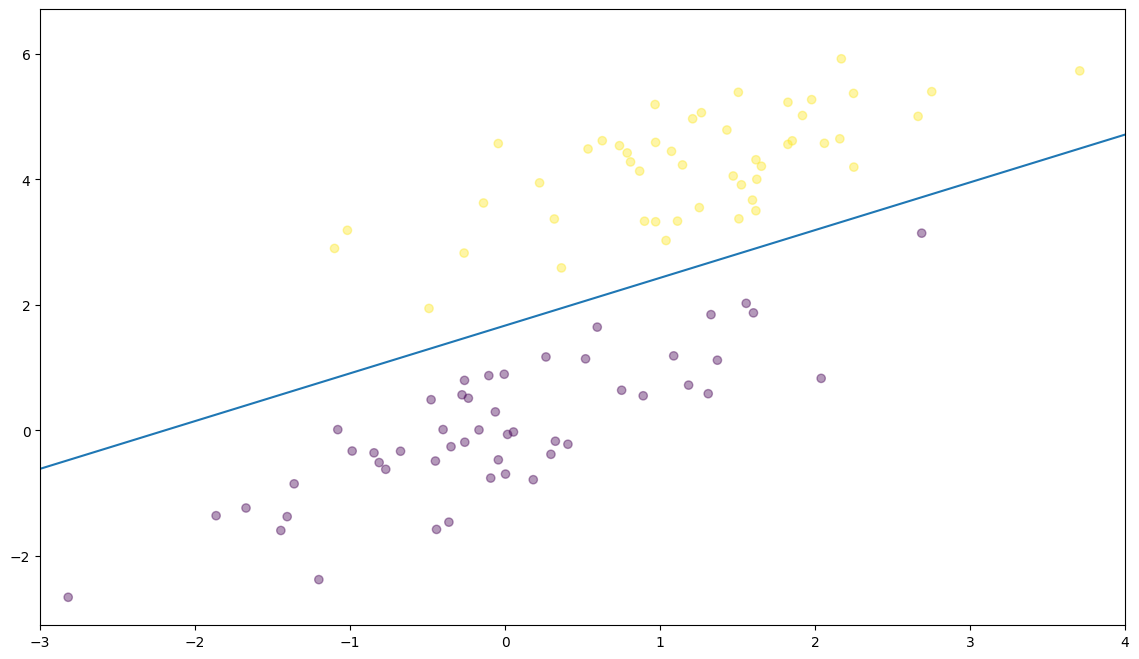

In [30]:
def myline(x):
    return line(x,weights[0],weights[1],weights[2])

plt.figure(figsize=(14,8))
plt.xlim([-3,4])
plt.scatter(dataset[:, 0], dataset[:, 1], c = labels, alpha = .4)
plt.plot([-3,4],[myline(-3),myline(4)])

final_scores = np.dot(data_with_intercept, weights)
preds = np.round(sigmoid(final_scores))
print('Accuracy: {0}'.format((preds == labels).sum().astype(float) / len(preds)))

# 2) Logistic regression on real dataset



Let us use the fantastic notebooks from https://physics.bu.edu/~pankajm/MLnotebooks.html, a terrific book for ML newcomers especially if they come from physics. We will consider again our friend MNIST, remember the lecture on KNN? First a bit of history on this famous dataset:


The MNIST classification problem is one of the classical ML problems for learning classification on high-dimensional data with a fairly sizable number of examples (60000). Yann LeCun and collaborators collected and processed $70000$ handwritten digits (60000 are used for training and 10000 for testing) to produce what became known as one of the most widely used datasets in ML: the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. Each handwritten digit comes in a grayscale square image in the shape of a $28\times 28$ pixel grid. Every pixel takes a value in the range $[0,255]$, representing $256$ nuances of the gray color. The problem of image classification finds applications in a wide range of fields and is important for numerous industry applications of Machine Learning.

 ### SoftMax regression:
 Before we consider two possible labels for our data, you can easily guess that it is amenable to have more than one in this case.

 Do not worry! We can easily generalize what we said before.


We will use SoftMax regression, which can be thought of as a statistical model which assigns a probability that a given input image corresponds to any of the 10 handwritten digits. The model is a generalization of the logistic regression and reads:
$$
p(y_i=j|\vec{x}_i;\vec{w}) = \frac{e^{-\vec{w}_j^T \vec{x}}}{\sum_{k=0}^9 e^{-\vec{w}_k^T\vec{x} }},
$$
Where $p(y_i=j|\vec{x}_i;\vec{w})$ is the probability that input $\vec{x}_i$ is the $j$-th digit, $j\in[0,9]$.
The model also has 10 weight vectors $\vec{w}_j$ which we will train below. Finally, one can use this information for prediction by taking the value of $y_i$ for which this probability is maximized:
\begin{align}
y_{pred}=\arg\max_i p(y=i|\vec{x})
\end{align}

First thing to do is to import the dataset and preprocess the data:


In [10]:
import time


from sklearn.datasets import fetch_openml # MNIST data
from sklearn.linear_model import LogisticRegression ##
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state

print(__doc__)

# Turn down for faster convergence
train_size = 60000
test_size = 10000

### load MNIST data from https://www.openml.org/d/554
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)


Automatically created module for IPython interactive environment


In [11]:
X = np.asarray(X)
y = np.asarray(y)

Let's plot an image to see how it looks like with plt.imshow.

'9'

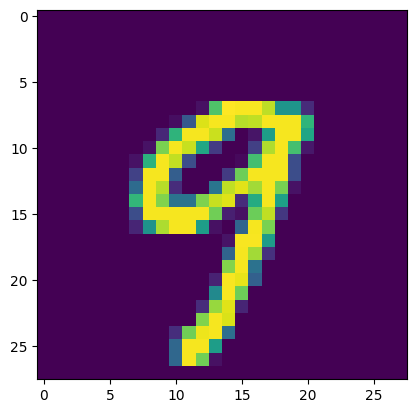

In [12]:
plt.imshow(X[45,:].reshape(28,28))
y[45]

We shuffle the data and we do the test-train splitting.

In [13]:
# shuffle data
random_state = check_random_state(0)
permutation = random_state.permutation(X.shape[0])
X = X[permutation]
y = y[permutation]
X = X.reshape((X.shape[0], -1))
# pick training and test data sets
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=train_size,test_size=test_size) #

We preproccess the data and use StandardScaler to have zero mean and unit variance. Pay attention that we do that only on the training set!

In [14]:
# scale data to have zero mean and unit variance [required by regressor]
scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train) ##
#X_test = scaler.transform(X_test)

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Since it's a classification problem, and normally Y_train is not allowed to scale

**Exercise**
 1. You need to learn how to read a Python documentation. Search on the internet how to implement softmax regression.
 2. Fix the value of the regularization to be $10^{-5}$. Fit the data and compute two quantities:
   - Sparsity of the weights (percentage of non-zero weights)
   - Score (i.e. accuracy)

In [15]:
# https://awjuliani.medium.com/simple-softmax-in-python-tutorial-d6b4c4ed5c16
# apply logistic regressor with 'sag' solver, C is the inverse regularization strength
t0=time.time()
clf = LogisticRegression(C=1e5,
                         multi_class='multinomial',
                         penalty='l2', solver='sag', tol=0.1)
# fit data
clf.fit(X_train_scaled, y_train)
# percentage of nonzero weights
sparsity = np.mean(clf.coef_ == 0) * 100
# compute accuracy
score = clf.score(X_test_scaled, y_test)

#display run time
run_time = time.time() - t0
print('Example run in %.3f s' % run_time)

print("Sparsity with L2 penalty: %.2f%%" % sparsity)
print("Test score with L2 penalty: %.4f" % score)

# define the vector of parameters as
coef = clf.coef_.copy()

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Example run in 4.708 s
Sparsity with L2 penalty: 8.80%
Test score with L2 penalty: 0.8932


##### Let us see how we can actually plot the weights against the pixels!!

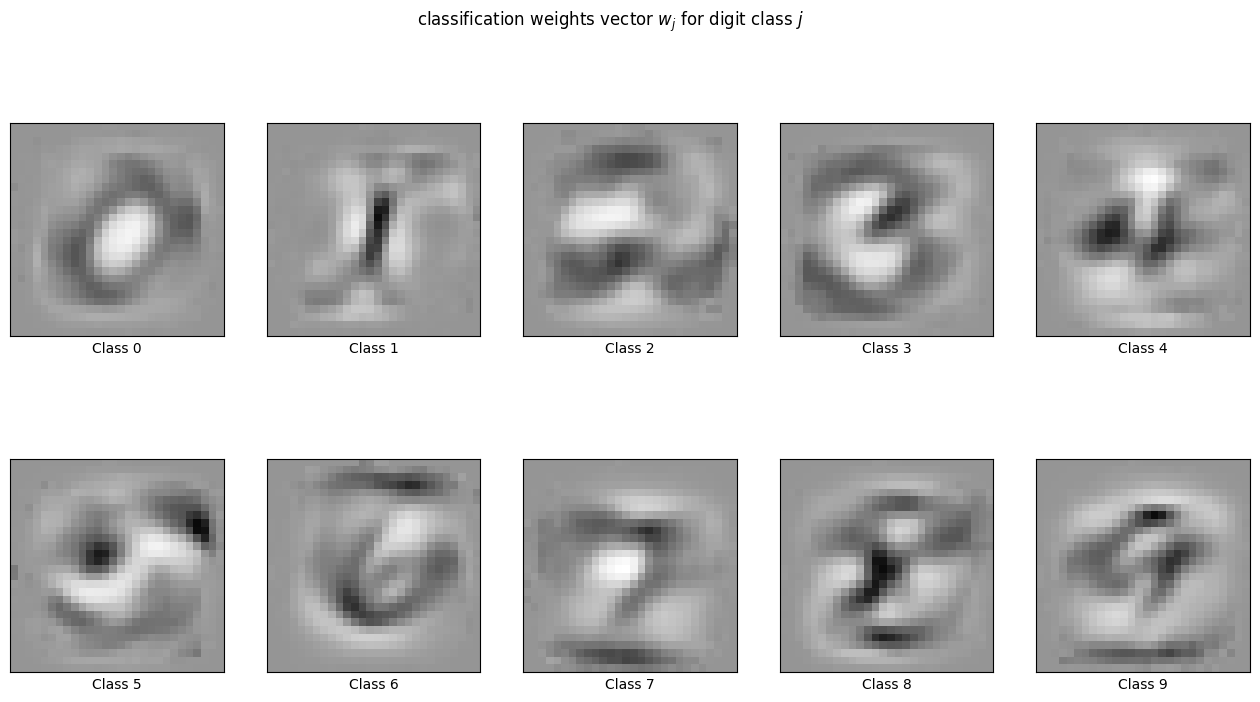

In [16]:
# plot weights vs the pixel position
plt.figure(figsize=(16, 8))
scale = np.abs(coef).max()
for i in range(10):
    l2_plot = plt.subplot(2, 5, i + 1)
    l2_plot.imshow(coef[i].reshape(28, 28), interpolation='nearest',
                   cmap=plt.cm.Greys, vmin=-scale, vmax=scale)
    l2_plot.set_xticks(())
    l2_plot.set_yticks(())
    l2_plot.set_xlabel('Class %i' % i)
plt.suptitle('classification weights vector $w_j$ for digit class $j$')
plt.show()

# 3) SVM Classification on real dataset

## Evaluated Part

**Exercise**
 1. Repeat what you did for softmax regression for an Support Vector Machine (SVM) linear classifier.
 2. Go and search the Python doc for SVM classifier. Choose the linear one.
 3. Fit the data using the default value of regularization and compare with an optimized value using CV.

In [17]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC


t0=time.time()
# clf_svc = LinearSVC()
clf_svc = LinearSVC(penalty = 'l2', tol=0.1, C=1.0, dual=False, max_iter=1500, random_state=42) # C is the Hyperparameter

# In MNIST, number of samples (60,000) >> numbers of features (784)
# Dual is learning in dimension 60000, while primal problem is learning in dimension 784
# So choose dual = 'False' to disable solving dual problem

# fit data
clf_svc.fit(X_train_scaled, y_train)

# percentage of nonzero weights
sparsity_svc = np.mean(clf_svc.coef_ == 0) * 100

# compute accuracy
score_svc = clf_svc.score(X_test_scaled, y_test)

#display run time
run_time = time.time() - t0
print('Example run in %.3f s' % run_time)

print("Sparsity with L2 penalty: %.2f%%" % sparsity_svc)
print("Test score with L2 penalty: %.4f" % score_svc)

# define the vector of parameters as
coef_svc = clf_svc.coef_.copy()

Example run in 76.293 s
Sparsity with L2 penalty: 8.80%
Test score with L2 penalty: 0.9076


In [18]:
# GridSearch and Cross Validation (Reference from TP 6 (5))
from sklearn import preprocessing
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV

#--- Make a Pre-processing + Fitting Pipeline ---#
pipe_svc = make_pipeline(preprocessing.StandardScaler(), clf_svc) # Two consecutive transformation


#--- Define CV Splitting ---#
cv = ShuffleSplit(n_splits=5, test_size=0.05, random_state=1) # Only 5 sub data sets, boost train

#--- Define the Parameters to Search ---#
param_grid = [
    # IMPORTANT: When using a pipeline, parameter names must be prefixed
    # with the step name (in lowercase) followed by two underscores.
    # make_pipeline automatically names LinearSVC() as 'linearsvc'.
    {'linearsvc__C': np.logspace(-2,2,5)} # we do CV for values of alpha between 0.01 and 100
]

#--- Define CV ---#
print("Running GridSearchCV...")
t0=time.time()
cv_svc = GridSearchCV(pipe_svc, param_grid, scoring='accuracy', cv=cv, n_jobs=-1, verbose=2, return_train_score=True)

#--- Run CV ---#
cv_svc.fit(X_train,y_train)

# Display run time
run_time = time.time() - t0

#--- Record CV Optimizing Hyper-Params ---#
cvOptC = cv_svc.best_params_['linearsvc__C']
cvOptParams = cv_svc.best_estimator_.named_steps['linearsvc'].coef_
print(f"Best C value found by GridSearchCV: {cvOptC}")

best_clf_pipeline = cv_svc.best_estimator_


# Compute accuracy with optimal C
print("Computing accuracy...")
score_svc_optimized = best_clf_pipeline.score(X_test, y_test)

print("Test score with L2 penalty (Optimized C): %.4f" % score_svc_optimized)

# The similar scores are very likely beacause of noise and relative small GridSearch parameter range
# However, they are both good hyperparameters 'C'

Running GridSearchCV...
Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best C value found by GridSearchCV: 0.01
Computing accuracy...
Test score with L2 penalty (Optimized C): 0.9068
